In [1]:
from SLCP.datasets import datasets
from SLCP import config
from SLCP.cqr import helper
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from ACP.acv_explainers import ACXplainer
from ACP.acv_explainers.utils import mean_score, quantile_score
from SLCP.conformal import ConformalPred
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

/home/xxxxx/anaconda3/envs/acv3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0. Experiment setup

In [2]:
random_seed = 2022

base_dataset_path = '/home/xxxxx/acp_experiments/SLCP/datasets/'
dataset_name = 'star'
model_name = 'random_forest'
test_ratio = 0.25
valid_ratio = 0.5

alpha = 0.1
level = 1 - alpha

# METRICS
coverages = {}
lengths = {}
lengths_residuals = {}
y_lower = {}
y_upper = {}
r = {}

In [3]:
estimator_map = {'SPLIT': 'mean', 'SLCP': 'mean', 'CQR': 'quantile', 'LCP-RF': 'mean', 'LCP-RF-Group': 'mean',
                 'QRF_train': 'mean', 'SPLIT-G':'mean'}
color_map = {'SPLIT': 'red', 'SLCP': 'red', 'CQR': 'red', 'LCP-RF': 'red', 'LCP-RF-Group': 'red',
             'QRF_train': 'red', 'SPLIT-G':'red'}
model_map = {'random_forest': 'Random Forest', 'linear': 'Linear Regression', 'neural_net': 'Neural Network',
             'kde': 'Constant', 'xgboost': 'XGBRegressor'}

### 1. Import datasets

In [4]:
X_train, X_test, y_train, y_test = datasets.GetDataset(dataset_name, base_dataset_path, random_seed, test_ratio)

x_train, x_test = X_train.astype(np.double), X_test.astype(np.double)
y_train, y_test = y_train.astype(np.double).reshape(-1), y_test.astype(np.double).reshape(-1)

in_shape = x_train.shape[1]
n_train = x_train.shape[0]

idx = np.random.permutation(n_train)
n_half = int(np.floor(n_train * valid_ratio))
idx_train, idx_cal = idx[:n_half], idx[n_half:]

### 2. Train model

In [5]:
if model_name == 'random_forest':
    mean_estimator = RandomForestRegressor(n_estimators=config.RandomForecastParams.n_estimators,
                                           min_samples_leaf=config.RandomForecastParams.min_samples_leaf,
                                           max_features=in_shape,
                                           random_state=config.RandomForecastParams.random_state)
    quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                               fit_params=None,
                                                               quantiles=config.ConformalParams.quantiles,
                                                               params=config.RandomForecastParams)

elif model_name == 'xgboost':
    mean_estimator = XGBRegressor(learning_rate =0.01,
                                 n_estimators=1000,
                                 max_depth=10,
                                 min_child_weight=6,
                                 gamma=0,
                                 subsample=0.8,
                                 colsample_bytree=0.8,
                                 reg_alpha=0.005,
                                 nthread=4,
                                 scale_pos_weight=1,
                                 seed=27)
    quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                               fit_params=None,
                                                               quantiles=config.ConformalParams.quantiles,
                                                               params=config.RandomForecastParams)


elif model_name == 'linear':
    mean_estimator = helper.MSELR_RegressorAdapter(model=None,
                                                   in_shape=in_shape,
                                                   epochs=config.LinearParams.epochs,
                                                   lr=config.LinearParams.lr,
                                                   batch_size=config.LinearParams.batch_size,
                                                   wd=config.LinearParams.wd,
                                                   test_ratio=config.LinearParams.test_ratio,
                                                   random_state=config.LinearParams.random_state)

    quantile_estimator = helper.QLR_RegressorAdapter(model=None,
                                                     in_shape=in_shape,
                                                     epochs=config.LinearParams.epochs,
                                                     lr=config.LinearParams.lr,
                                                     batch_size=config.LinearParams.batch_size,
                                                     wd=config.LinearParams.wd,
                                                     test_ratio=config.LinearParams.test_ratio,
                                                     random_state=config.LinearParams.random_state)

elif model_name == 'neural_net':

    mean_estimator = helper.MSENet_RegressorAdapter(model=None,
                                                    in_shape=in_shape,
                                                    hidden_size=config.NeuralNetParams.hidden_size,
                                                    epochs=config.NeuralNetParams.epochs,
                                                    lr=config.NeuralNetParams.lr,
                                                    batch_size=config.NeuralNetParams.batch_size,
                                                    dropout=config.NeuralNetParams.dropout,
                                                    wd=config.NeuralNetParams.wd,
                                                    test_ratio=config.NeuralNetParams.test_ratio,
                                                    random_state=config.NeuralNetParams.random_state)

    quantile_estimator = helper.AllQNet_RegressorAdapter(model=None,
                                                         in_shape=in_shape,
                                                         hidden_size=config.NeuralNetParams.hidden_size,
                                                         epochs=config.NeuralNetParams.epochs,
                                                         lr=config.NeuralNetParams.lr,
                                                         batch_size=config.NeuralNetParams.batch_size,
                                                         dropout=config.NeuralNetParams.dropout,
                                                         wd=config.NeuralNetParams.wd,
                                                         test_ratio=config.NeuralNetParams.test_ratio,
                                                         random_state=config.NeuralNetParams.random_state)

elif model_name == 'kde':
    mean_estimator = helper.MSEConst_RegressorAdapter()

    quantile_estimator = helper.QConst_RegressorAdapter()



methods = ['SPLIT', 'SPLIT-G', 'SLCP', 'CQR', 'LCP-RF', 'LCP-RF-Group', 'QRF_train']

# mean_estimator.fit(x_train[idx_train], y_train[idx_train])
quantile_estimator.fit(x_train[idx_train], y_train[idx_train])

pred_quantile = quantile_estimator.predict(x_test).astype(np.float64)

# v_test = mean_score(mean_estimator.predict(x_test), y_test)
v_test_quantile = quantile_score(quantile_estimator.predict(x_test), y_test)

### SPLIT conformal or CQR

In [6]:
cp_cqr = ConformalPred(model=quantile_estimator,
                       method='cqr',
                       data_name=dataset_name,
                       ratio=config.ConformalParams.valid_ratio,
                       x_train=x_train,
                       x_test=x_test,
                       y_train=y_train,
                       y_test=y_test,
                       k=config.ConformalParams.k)

cp_cqr.idx_train = idx_train
cp_cqr.idx_cal = idx_cal
cp_cqr.fit()

y_lower_cqr, y_upper_cqr = cp_cqr.predict()
y_lower['CQR'] = y_lower_cqr
y_upper['CQR'] = y_upper_cqr
r['CQR'] = y_upper_cqr - y_lower_cqr

### SLCP conformal


In [7]:
cp_slcp = ConformalPred(model=quantile_estimator,
                        method='slcp-rbf',
                        data_name=dataset_name,
                        ratio=config.ConformalParams.valid_ratio,
                        x_train=x_train,
                        x_test=x_test,
                        y_train=y_train,
                        y_test=y_test,
                        k=config.ConformalParams.k)

cp_slcp.idx_train = idx_train
cp_slcp.idx_cal = idx_cal
cp_slcp.fit()


y_lower_slcp, y_upper_slcp = cp_slcp.predict()
y_lower['SLCP'] = y_lower_slcp
y_upper['SLCP'] = y_upper_slcp
r['SLCP'] = y_upper_slcp - y_lower_slcp

### LCP-RF 

#### LCP-RF calibration

In [8]:
# LCP-RF
level = 1 - config.ConformalParams.alpha
acv_xplainer = ACXplainer(classifier=False, n_estimators=200,
                          mtry=int(in_shape),
                          max_depth=20,
                          min_node_size=10,
                          seed=config.RandomForecastParams.random_state)

acv_xplainer.fit_calibration(x_train[idx_cal], y_train[idx_cal], quantile_estimator,
                             bygroup=True, training_conditional=True, training_conditional_one=True,
                             quantile=level, score_type='quantile', only_qrf=False)

Training calibration of QRF


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:36<00:00,  1.35it/s]


Marginal calibration of RF-LCP


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 64.50it/s]


Training-conditional calibration of RF-LCP


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 405/405 [00:09<00:00, 41.15it/s]

Training-conditional-one calibration of RF-LCP
Computing communities using the RF weights



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.92it/s]


Marginal calibration of Group-wise RF-LCP
Training-conditional calibration of Group-wise LCP


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 405/405 [00:02<00:00, 168.62it/s]


#### QRF-TC PI

In [9]:
r['QRF_TC'] = acv_xplainer.predict_qrf_r(x_test)
y_lower['QRF_TC'] = pred_quantile[:, 0] - r['QRF_TC']
y_upper['QRF_TC'] = pred_quantile[:, 1] + r['QRF_TC']

#### LCP-RF PI

In [10]:
r['LCP-RF'], s_lcp_all = acv_xplainer.predict_rf_lcp_train_one(x_test, level)
y_lower['LCP-RF'] = pred_quantile[:, 0] - r['LCP-RF']
y_upper['LCP-RF'] = pred_quantile[:, 1] + r['LCP-RF']

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 541/541 [00:15<00:00, 36.06it/s]


#### LCP-RF-G PI

In [11]:
r['LCP-RF-G'], y_lcp_group = acv_xplainer.predict_rf_lcp_bygroup_train(x_test, level)
y_lower['LCP-RF-G'] = pred_quantile[:, 0] - r['LCP-RF-G']
y_upper['LCP-RF-G'] = pred_quantile[:, 1] + r['LCP-RF-G']

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 541/541 [00:03<00:00, 165.47it/s]


### Split G

In [12]:
print('SPLIT-Groupwise')
acv = acv_xplainer
y_test_base = np.zeros(x_test.shape[0])
w_test = acv.compute_forest_weights(x_test, y_test_base, acv.x_cali, acv.r_cali)
groups = np.unique(acv.communities)
p_test = np.zeros(shape=(x_test.shape[0], len(groups)))
for group in groups:
    p_test[:, group] = np.sum(w_test[:, acv.communities == group], axis=1)

group_test = np.argmax(p_test, axis=1)

n_test = x_test.shape[0]
r_split_group = np.zeros(n_test)


r_cali = acv.r_cali
for i in tqdm(range(n_test)):
    group_idx = acv.communities == group_test[i]

    n_group = np.sum(group_idx)
    r_candidate = r_cali[group_idx]

    k_star = np.int((n_group + 1) * (level))
    r_split_group[i] = np.sort(r_candidate)[k_star-1]

y_lower['SPLIT-G'] = pred_quantile[:, 0] - r_split_group
y_upper['SPLIT-G'] = pred_quantile[:, 1] + r_split_group
r['SPLIT-G'] = r_split_group

SPLIT-Groupwise


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 541/541 [00:00<00:00, 50004.81it/s]


### Metrics

In [13]:
methods = ['CQR', 'SLCP', 'LCP-RF', 'LCP-RF-G', 'QRF_TC']

In [16]:
for method in methods:
    coverages[method], lengths[method] = helper.compute_coverage(y_test, y_lower[method], y_upper[method],
                                                                 config.ConformalParams.alpha, method)
    
    lengths_residuals[method] = np.mean(np.abs(v_test_quantile - r[method]))

CQR: Percentage in the range (expecting 90.00): 89.648799
CQR: Average length: 768.252345
SLCP: Percentage in the range (expecting 90.00): 90.388170
SLCP: Average length: 795.912656
LCP-RF: Percentage in the range (expecting 90.00): 87.800370
LCP-RF: Average length: 765.863622
LCP-RF-G: Percentage in the range (expecting 90.00): 90.942699
LCP-RF-G: Average length: 872.283109
QRF_TC: Percentage in the range (expecting 90.00): 90.203327
QRF_TC: Average length: 792.336428


In [17]:
r_data = pd.DataFrame.from_dict(r)

v_error = r_data.copy()
for method in methods:
    v_error[method] = np.abs(v_error[method] - v_test_quantile)/np.abs(v_test_quantile) 

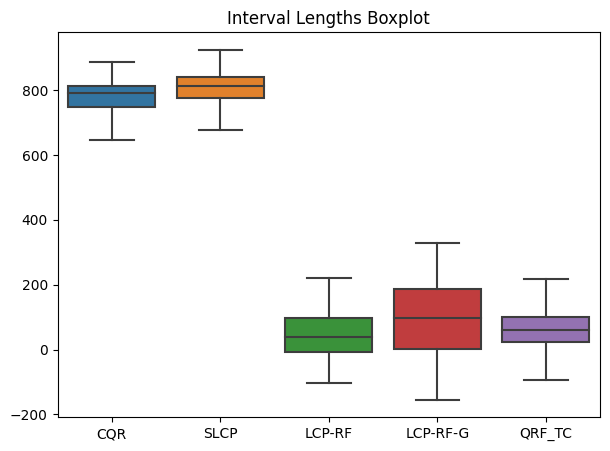

In [18]:
fig, ax = plt.subplots(dpi=100, figsize=(7, 5))
g = sns.boxplot(data=r_data[methods], orient="v", ax=ax, showfliers = False,
           saturation=0.75, width=0.8, dodge=True, fliersize=5, linewidth=None, whis=1.5)
g.set_title('Interval Lengths Boxplot')
plt.show()

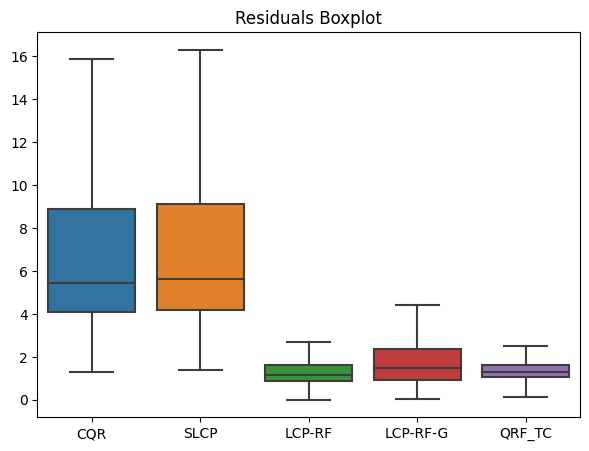

In [19]:
fig, ax = plt.subplots(dpi=100, figsize=(7, 5))
g = sns.boxplot(data=v_error[methods], orient="v", ax=ax, showfliers = False,
           saturation=0.75, width=0.8, dodge=True, fliersize=5, linewidth=None, whis=1.5)
g.set_title('Residuals Boxplot')
plt.show()